# Management and Analysis of Physics Datasets

## *Session 1*

#### Federico Agostini, Federico Bottaro

### Part A

In the following I write the command I used in the shell to accomplish the different tasks.

```bash
# as ROOT
# download redis software to REDIS_DIR=/path/to/redis/folder location
cd $REDIS_DIR
wget http://download.redis.io/releases/redis-5.0.5.tar.gz
# unzip folder
gunzip redis-5.0.5.tar.gz ; tar -xvf redis-5.0.5.tar
# compile the package
cd redis-5.0.5; make
# launch the server in background
cd src/; ./redis-server &

# as USER
# add redis /src folder to PATH
export PATH=$REDIS_DIR/redis-5.0.5/src/:$PATH
```

### Part B


Implementation of a *Hash Table for File Location*, following exercises 3.1.X as described [here](https://apeters.web.cern.ch/apeters/csc2018/CloudStorage.html). The starting point of each exercise is highlighted by a comment with its number in curly brakets (e.g. `# {3.1.4}`).

In the following, only the commands used in the bash are reported, while I omit the content of the different functions `cloud_*`, which can be retrieved in the above link.

```bash
# download 'cloud.sh' file
wget https://apeters.web.cern.ch/apeters/csc2018/_downloads/4eea42a0909a188c81ba98ae00d64083/cloud.sh
# load the library (this step needs to be done every time the file is modified; knowing that, in the following I will omit this command)
. cloud.sh

# {3.1.1}
sha1string /etc/passwd # 63ce9c1433c0fad87dcc9d5d22081acc7ff60df4 

# {3.1.2}
# from the description of 'h8d' function in 'cloud.sh':
### Convert a hexadecimal character (0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f) to decimal, divide by 2 and add 1 e.g
### - maps 0-f => 1-8

# {3.1.3}
hash=`sha1string /etc/passwd`

# {3.1.4}
hashkey=${hash:0:1} # 4

# {3.1.5}
h8d $hashkey # 4

# {3.1.6}
filename="/etc/resolv.conf"
hash=`sha1string $filename`
hashkey=${hash:0:1} # value: 4
index=`h8d $hashkey` # value: 3
upload $filename $index $filename # uploaded to location 3

# {3.1.7}
download $index $filename ~/resolv.conf.newname

# {3.1.8}
list $index

# {3.1.9}
delete $index $filename

# {3.1.10}
# implement 'cloud_upload' and reload the library
# create 1kB file
dd if=/dev/zero of=1kB bs=1kB count=1
# upload 100 files with different names
for((i=0; i<100; i++)); do up_name=`uuidgen`; cloud_upload 1kB $up_name; done

# {3.1.11}
# implement 'cloud_download' and reload the library

# {3.1.12}
for name in 1 2 3 4 5 6 7 8; do list $name| wc -l; done # 11 11 13 17 10 9 11 18

# {3.1.13}
# implement 'cloud_rm' and reload the library

# {3.1.14}
# implement 'cloud_list' and reload the library
# count hte number of files
cloud_ls | wc -l
# timing 'cloud_ls'
time cloud_ls
```

### Part C

As result, I show the plot of the execution time of `cloud_ls` with different number of items in the storage. In the plots there is also a comparison with the performance obtained implementing a bucket in our storage (**Part E**, question **1**).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
cloud_ls = pd.read_csv("./cloud_ls_time_local.csv", comment="#", names=["n_files", "time", "time_bucket"])
cloud_ls

,n_files,time,time_bucket
0,100,0.095,0.014
1,500,0.103,0.018
2,1000,0.108,0.019
3,5000,0.201,0.040
4,10000,0.308,0.161
5,50000,0.804,0.462
6,75000,1.036,0.757
7,100000,1.341,0.762
8,1000000,7.450,6.393


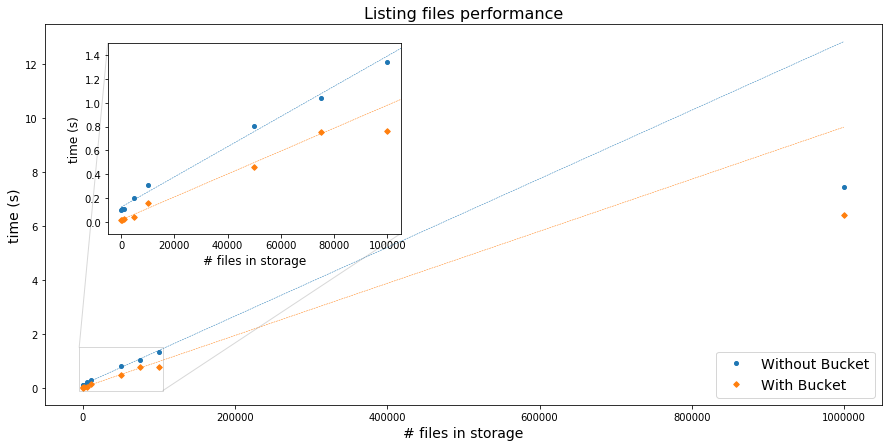

In [3]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(cloud_ls["n_files"], cloud_ls["time"],        "o", linewidth=.5, markersize=4, label="Without Bucket")
ax.plot(cloud_ls["n_files"], cloud_ls["time_bucket"], "D", linewidth=.5, markersize=4, label="With Bucket")
slope,        intercept,        _, _, _ = stats.linregress(cloud_ls["n_files"][:7], cloud_ls["time"][:7])
slope_bucket, intercept_bucket, _, _, _ = stats.linregress(cloud_ls["n_files"][:7], cloud_ls["time_bucket"][:7]) 
x = np.linspace(0, 1e06, 100)
ax.plot(x, intercept+slope*x,                "--", color="C0", linewidth=.5)
ax.plot(x, intercept_bucket+slope_bucket*x,  "--", color="C1", linewidth=.5)
ax.set_xlabel("# files in storage", fontsize=14)
ax.set_ylabel("time (s)", fontsize=14)
ax.legend(loc="lower right", fontsize=14)
ax.set_title("Listing files performance", fontsize=16)
axins = ax.inset_axes([.075, .45, .35, .5])
axins.set_xlim(-5000, 105000)
axins.set_ylim(-0.1,1.5)
axins.plot(cloud_ls["n_files"], cloud_ls["time"],        "o", linewidth=.5, markersize=4)
axins.plot(cloud_ls["n_files"], cloud_ls["time_bucket"], "D", linewidth=.5, markersize=4)
axins.plot(x, intercept+slope*x,                "--", color="C0", linewidth=.5)
axins.plot(x, intercept_bucket+slope_bucket*x,  "--", color="C1", linewidth=.5)
axins.set_xlabel("# files in storage", fontsize=12)
axins.set_ylabel("time (s)", fontsize=12)
ax.indicate_inset_zoom(axins, edgecolor="gray", alpha=.3)
plt.show()

The scaling seems to follow a linear trend, if we exclude the value for one million files in the storage. This last value is lower with respect to the linear fit prevision (shown as dotted line). This trend may indicate the presence of a saturation behavior.

### Part D

To save the upload time for each one of the 1000000 files, I used the following commands, since `time` function lacks of many features compare to `/usr/bin/time`, while the latter does not accept commands present in `cloud.sh`:

```bash
# change TIMEFORMAT environment variable, so that the output of 'time' function is just the real time value
export TIMEFORMAT=%R
for((i=0; i<1000000; i++)); do up_name=`uuidgen`; (time cloud_upload 1kB $up_name) 2>> up_time_local.csv; done
```

As before, the plots show also the results for the upload function with the bucket implementation. 

In [4]:
up_time        = np.loadtxt("./up_time_local.csv")
up_time_bucket = np.loadtxt("./up_time_bucket_local.csv")

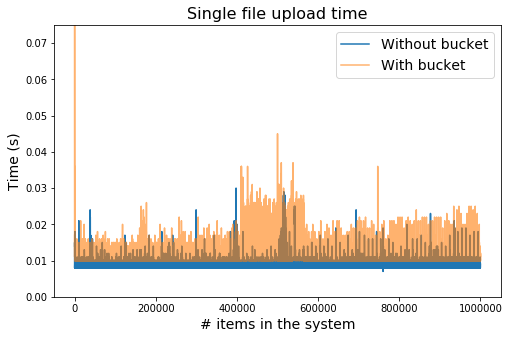

In [5]:
plt.figure(figsize=(8,5))
plt.plot(up_time, "-", alpha=1, label="Without bucket")
plt.plot(up_time_bucket, "-", alpha=.6, label="With bucket")
plt.legend(loc="upper right", fontsize=14)
plt.ylim(0, 0.075)
plt.xlabel("# items in the system", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.title("Single file upload time", fontsize=16)
plt.show()

The upload time seems to be independent of the number of items in the system.

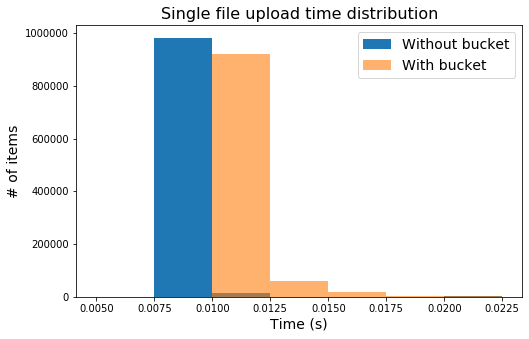

In [6]:
plt.figure(figsize=(8,5))
bins = [0.0025*i for i in range(2,10)]
plt.hist(up_time, bins=bins, alpha=1, label="Without bucket")
plt.hist(up_time_bucket, bins=bins, alpha=.6, label="With bucket")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("# of items", fontsize=14)
plt.title("Single file upload time distribution", fontsize=16)
plt.show()

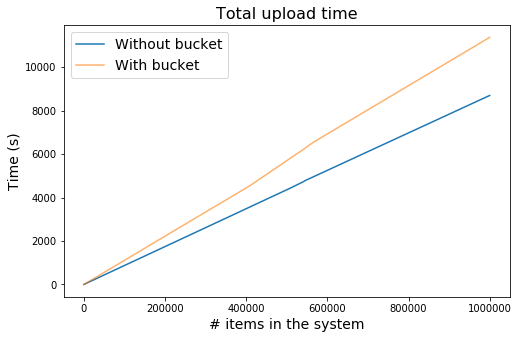

In [7]:
plt.figure(figsize=(8,5))
plt.plot(up_time.cumsum(), "-", alpha=1, label="Without bucket")
plt.plot(up_time_bucket.cumsum(), "-", alpha=.6, label="With bucket")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("# items in the system", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.title("Total upload time", fontsize=16)
plt.show()

### Part E

#### Question 1
See the plots above to get the answer. As expected, the time needed to list the files is less then before, while the upload time for each file is greater (due to the call to the additional `set_add` function). 

#### Question 2
If we implement an authentication overhead of 1 second for each `cloud_*` function call, we need to sum 1 second for each upload time: so, in total, we would have $10^6$ seconds in addition to the total upload time displayed above. On the other hand, in the listing operation the additional time would be just 1 second independently on the number of files stored.

In order to limit the impact of the security overhead, we can demand to check the authentication every N function calls instead of every one. Or, if we do a bulk upload (or download/remove), we can ask the security check to be performed only at the first action. \
Another valid option is to grant access for a limited time, and after that the user needs to pass the security check again in order to continue the operation.

#### Question 3
In order to reduce the probability of data loss we need to implement data redundancy. In particular, the first solution could be a *RAID 1* system, where we store copies of data in one or more different disks (data mirroring). Another option is to use a system as *RAID 5* or *RAID 6*, where we save information about the parity, that can be used to reconstruct corrupted data. Even more complex systems can be built, where the mirroring of data is used with a single, double, ... parity information. \
In addition, we can grant permission to perform irrecoverable commands (such as deleting files or purging the entire database) only to some confident accounts, in order to avoid data loss due to user (accidental) mistakes. Or, even more, these actions could require a two or more steps authentication procedure; moreover, before completely deleting files, they can be moved in a quarantine zone for a limited period of time, before being definitely purged. 